#Walmart Sales Prediction


##Data Overview

Dataset From : https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast

Walmart is a renowned retail corporation that operates a chain of hypermarkets. Here, Walmart has provided a data combining of 45 stores including store information and monthly sales. The data is provided on weekly basis. Walmart tries to find the impact of holidays on the sales of store. For which it has included four holidays’ weeks into the dataset which are Christmas, Thanksgiving, Super bowl, Labor Day. Here we are owing to Analyze the dataset given

**Objective** is to predict sales of store in a week. As in dataset size and time related data are given as feature, so analyze if sales are impacted by time-based factors and space- based factor. Most importantly how inclusion of holidays in a week soars the sales in store?

Total 16 numbers of attributes are provided in the Data set including Target variable. Attribute definition is:

**Target** : ทำนาย weekly sales(ยอดขายรายสัปดาห์) ตาม size and time related data
- Store: The store number
- Size: Size of the Store
- Dept: Department of the Store
- Date: Specifying the Week (Friday of every Week)
- Temperature: Average temperature in the region (in ℉)
- FuelPrice: Cost of fuel in the region
- MarkDown1-5: Anonymized data related to promotional markdowns that Walmart is running. Markdown data is only available after November 2011, and is not available for all stores all the time. Any missing value is marked with Null.
- CPI: Consumer price index
- Unemployment: Unemployment rate
- IsHoliday: Whether the week is a special holiday week
- Type : store types

Using the above given features, we have to predict the weekly sales of the store with given parameters.

In [ ]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.options.display.max_columns=100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_store = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IS1/Walmart Sales Forecasting/stores.csv') #store data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IS1/Walmart Sales Forecasting/train.csv') # train set

In [ ]:
df_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IS1/Walmart Sales Forecasting/features.csv') #external information

In [ ]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [ ]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column

In [ ]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column

In [ ]:
df.head() # ready data set

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [ ]:
df.shape

(421570, 16)

In [ ]:
columns = df.columns
print("******************* Numeric field *******************\n")
for i in range(len(columns)):
    if df[columns[i]].dtypes==float:
        print("unique number of {} -> {}".format(columns[i], len(df[columns[i]].unique())))
    if df[columns[i]].dtypes==int:
        print("unique number of {} -> {}".format(columns[i], len(df[columns[i]].unique())))
print("\n******************* Categorical field *******************\n")
for i in range(len(columns)):
    if df[columns[i]].dtypes==object:
        print("unique number of {} -> {}".format(columns[i], len(df[columns[i]].unique())))

******************* Numeric field *******************

unique number of Store -> 45
unique number of Dept -> 81
unique number of Weekly_Sales -> 359464
unique number of Temperature -> 3528
unique number of Fuel_Price -> 892
unique number of MarkDown1 -> 2278
unique number of MarkDown2 -> 1500
unique number of MarkDown3 -> 1663
unique number of MarkDown4 -> 1945
unique number of MarkDown5 -> 2294
unique number of CPI -> 2145
unique number of Unemployment -> 349
unique number of Size -> 40

******************* Categorical field *******************

unique number of Date -> 143
unique number of Type -> 3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


<Axes: >

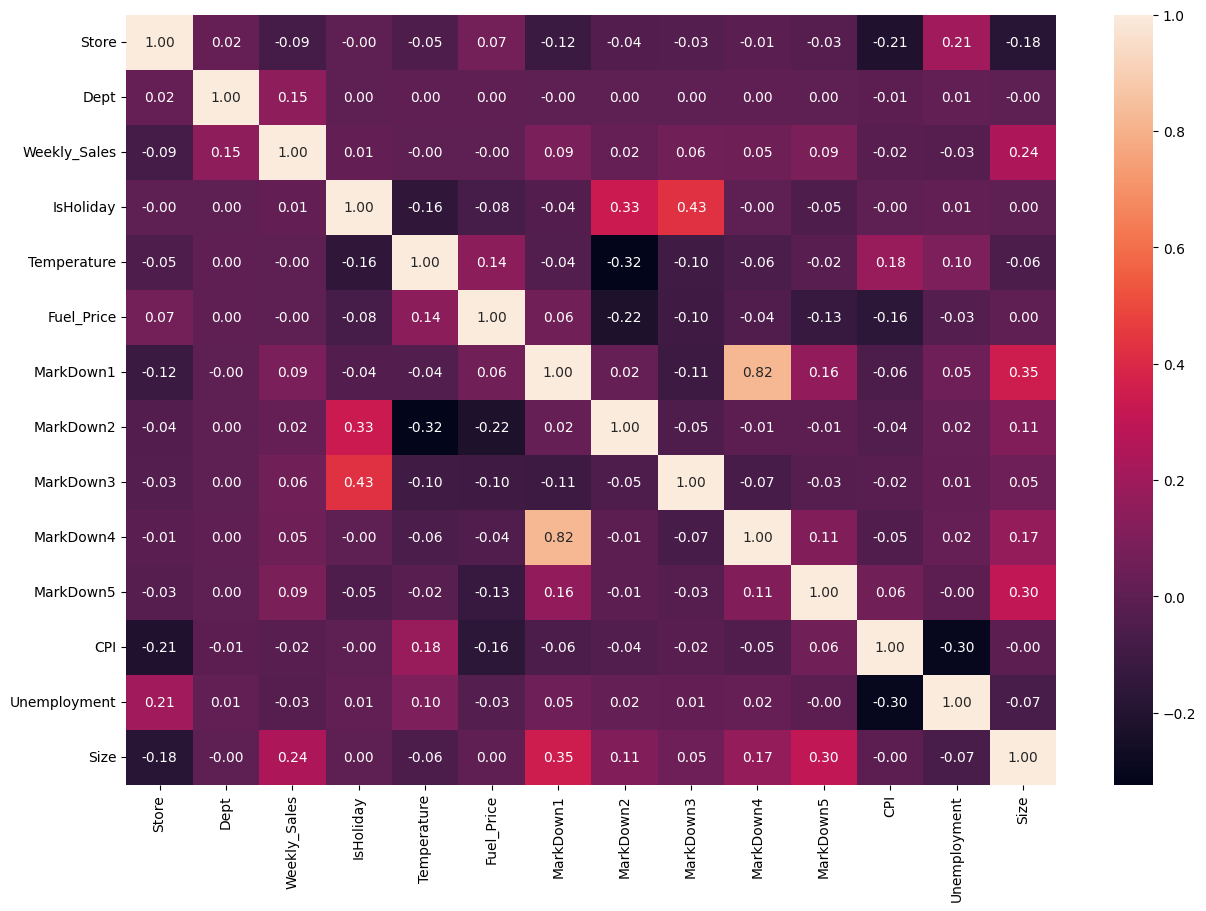

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data=df.corr(), annot=True,fmt = ".2f")

##Store & Department Numbers

In [ ]:
df['Store'].nunique() # number of different values

45

In [ ]:
df['Dept'].nunique() # number of different values

81

In [ ]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

จำนวนร้านค้าตั้งแต่เลขที่ 1 ถึง 45, แผนกของร้านค้าตั้งแต่เลขที่ 1 ถึง 99 แต่มีทั้งหมด 81 แผนกโดยที่เลขไม่ได้เรียงกัน


จากตารางจะเห็นได้ว่าคอลัมน์ Weekly_Sales มีค่าบางอย่างที่ไม่ถูกต้อง เช่น มีค่า 0 และติดลบสำหรับยอดขายรายสัปดาห์ แต่ยอดขายไม่สามารถติดลบได้ และเป็นไปไม่ได้ที่แผนกใดแผนกหนึ่งจะไม่ขายอะไรเลยทั้งสัปดาห์

In [ ]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [ ]:
df = df.loc[df['Weekly_Sales'] > 0]

In [ ]:
df.shape # new data shape

(420212, 16)

##Date

In [ ]:
df['Date'].head(5).append(df['Date'].tail(5)) # to see first and last 5 rows.

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

คอลัมน์ Date เริ่มวันที่ 5th of February 2010 ถึง 26th of October 2012.

##IsHoliday column

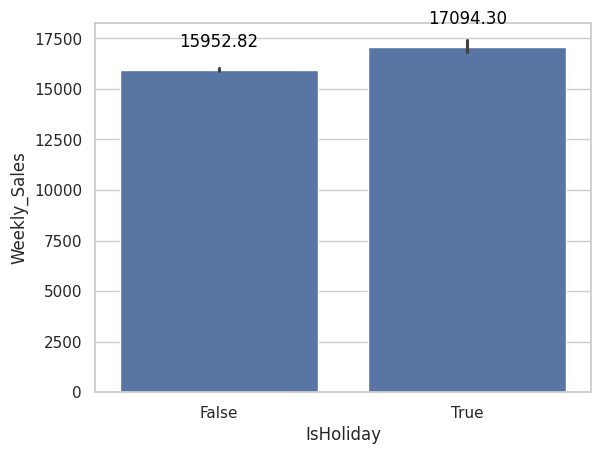

In [ ]:
#IsHoliday
sns.set(style="whitegrid")
ax = sns.barplot(x="IsHoliday", y="Weekly_Sales", data=df)

# เพิ่มตัวเลขข้างบนแท่ง
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 20), textcoords='offset points')

# แสดงกราฟ
plt.show()

In [ ]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [ ]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique()

133

All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

I want to see differences between holiday types. So, I create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False.

In [ ]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [ ]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [ ]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [ ]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420212 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         420212 non-null  int64  
 1   Dept          420212 non-null  int64  
 2   Date          420212 non-null  object 
 3   Weekly_Sales  420212 non-null  float64
 4   IsHoliday     420212 non-null  bool   
 5   Temperature   420212 non-null  float64
 6   Fuel_Price    420212 non-null  float64
 7   MarkDown1     150181 non-null  float64
 8   MarkDown2     110904 non-null  float64
 9   MarkDown3     136651 non-null  float64
 10  MarkDown4     134518 non-null  float64
 11  MarkDown5     150929 non-null  float64
 12  CPI           420212 non-null  float64
 13  Unemployment  420212 non-null  float64
 14  Type          420212 non-null  object 
 15  Size          420212 non-null  int64  
 16  Super_Bowl    420212 non-null  object 
 17  Labor_Day     420212 non-null  object 
 18  Than

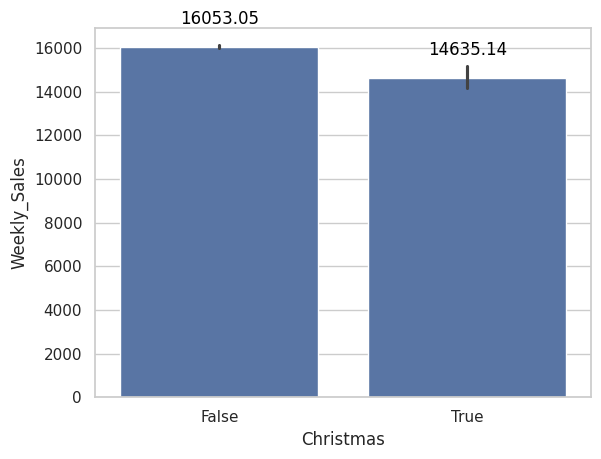

In [ ]:
# Christmas holiday vs not-Christmas
sns.set(style="whitegrid")
ax = sns.barplot(x="Christmas", y="Weekly_Sales", data=df)

# เพิ่มตัวเลขข้างบนแท่ง
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 20), textcoords='offset points')

# แสดงกราฟ
plt.show()

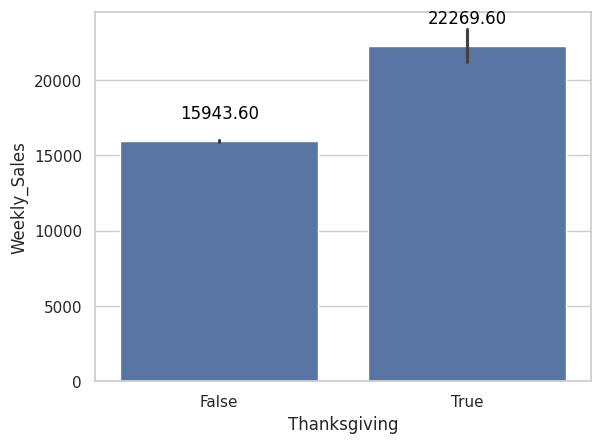

In [ ]:
# Thanksgiving holiday vs not-thanksgiving
sns.set(style="whitegrid")
ax = sns.barplot(x="Thanksgiving", y="Weekly_Sales", data=df)

# เพิ่มตัวเลขข้างบนแท่ง
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 20), textcoords='offset points')

# แสดงกราฟ
plt.show()

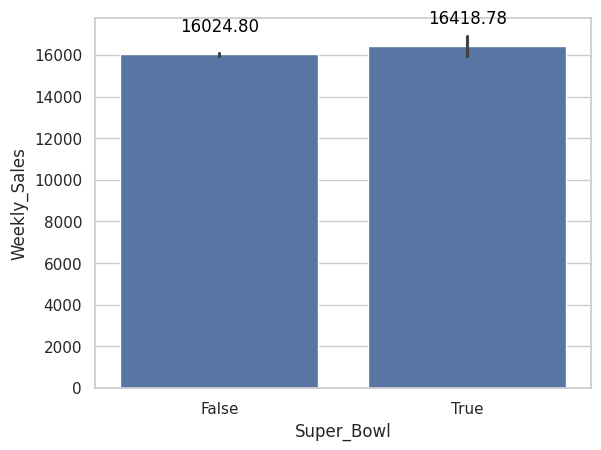

In [ ]:
# Super bowl holiday vs not-super bowl
sns.set(style="whitegrid")
ax = sns.barplot(x="Super_Bowl", y="Weekly_Sales", data=df)

# เพิ่มตัวเลขข้างบนแท่ง
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 20), textcoords='offset points')

# แสดงกราฟ
plt.show()

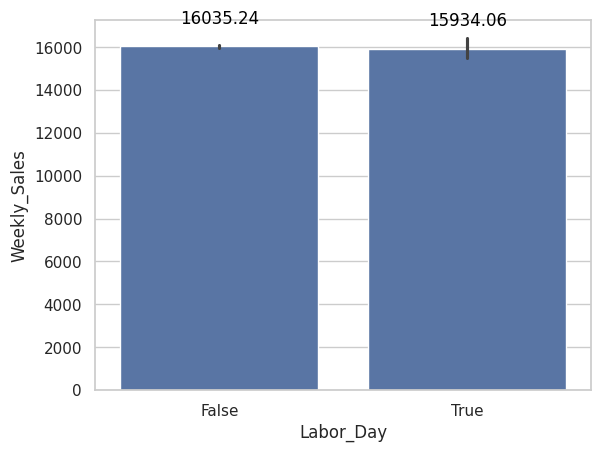

In [ ]:
# Labor day holiday vs not-labor day
sns.set(style="whitegrid")
ax = sns.barplot(x="Labor_Day", y="Weekly_Sales", data=df)

# เพิ่มตัวเลขข้างบนแท่ง
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 20), textcoords='offset points')

# แสดงกราฟ
plt.show()

กราฟแสดงให้เห็นว่า วันแรงงานและคริสต์มาส ไม่ได้เพิ่มยอดขายเฉลี่ยรายสัปดาห์ , ยอดขายในวัน Super Bowl ส่งผลดีต่อยอดขาย แต่ความแตกต่างสูงสุดคือช่วงวันขอบคุณพระเจ้า เพราะคนทั่วไปอาจจะนิยมซื้อของขวัญคริสต์มาสก่อนวันคริสต์มาส 1-2 สัปดาห์ จึงไม่ทำให้ยอดขายเปลี่ยนแปลงในสัปดาห์คริสต์มาส และมีการขายแบล็กฟรายเดย์ในสัปดาห์วันขอบคุณพระเจ้า

##Type Effect on Holidays

There are three different store types in the data as A, B and C.

In [ ]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

**percentages of store types.**

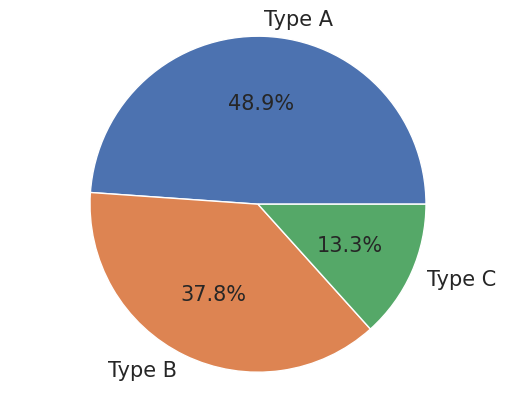

In [ ]:
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

In [ ]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

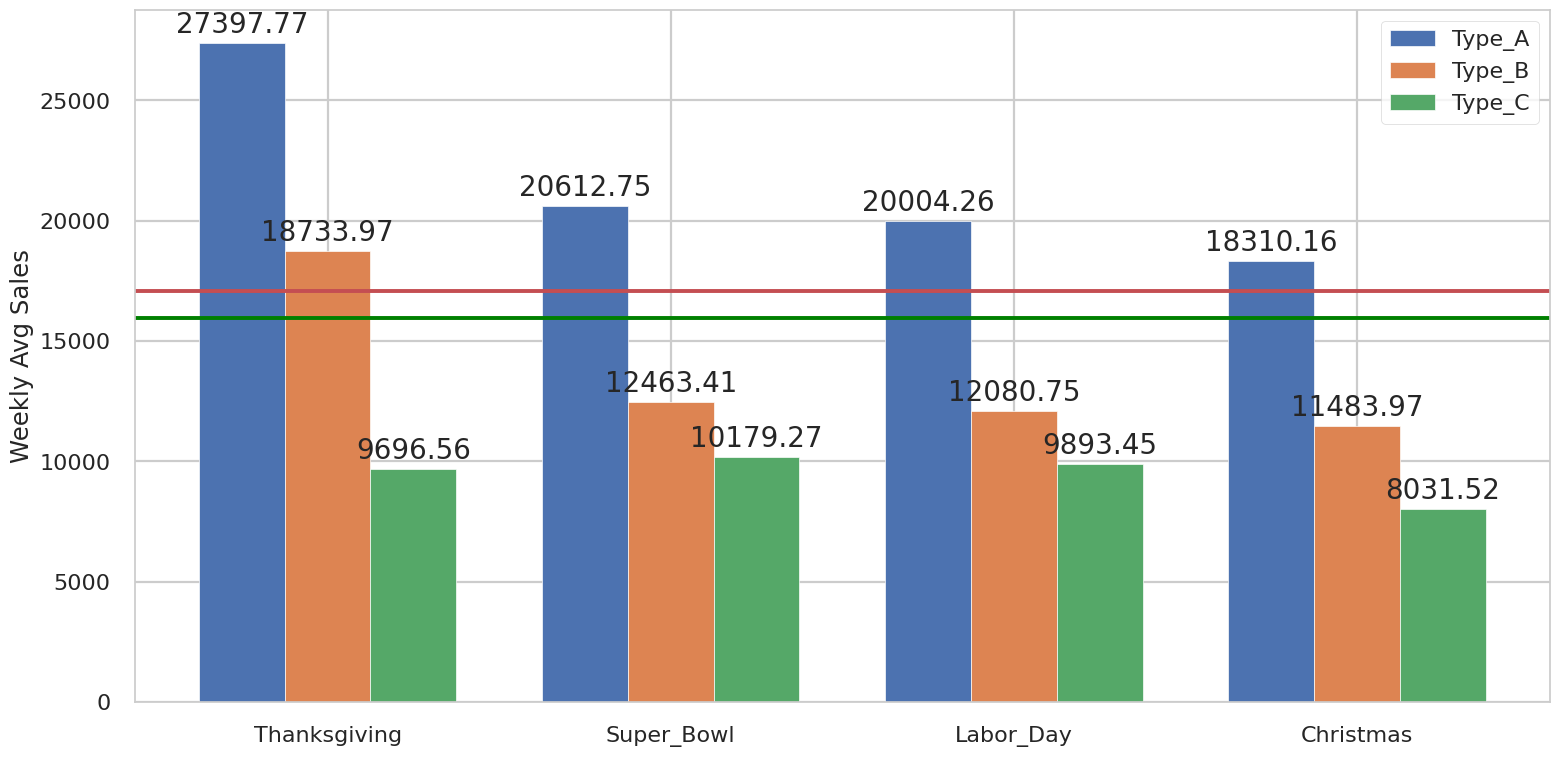

In [ ]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

จากกราฟจะเห็นได้ว่ายอดขายเฉลี่ยสูงสุดอยู่ในช่วงสัปดาห์ขอบคุณพระเจ้าระหว่างวันหยุด และสำหรับวันหยุดทั้งหมด ร้าน Type A มียอดขายสูงสุด

##To See the Size - Type Relation

In [ ]:
df_store.groupby('Type').describe()['Size'].round(2) # See the Size-Type relation

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


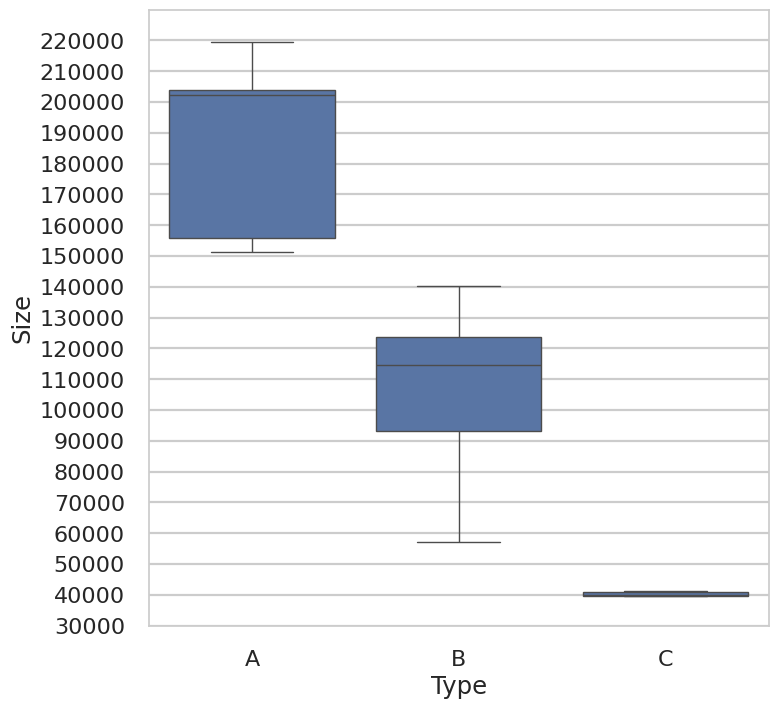

In [ ]:
plt.figure(figsize=(8,8)) # To see the type-size relation
plt.ylim(30000,230000)
plt.yticks(range(30000,230000,10000))
fig = sns.boxplot(x='Type', y='Size', data=df_store, showfliers=False)

ขนาดของประเภทร้านค้าสอดคล้องกับยอดขายตามที่คาดไว้ ร้านค้าขนาดสูงมียอดขายสูงขึ้น

##Markdown Columns

เปลี่ยน MarkDown ที่มีค่า NaN เป็น 0 เนื่องจากไม่มีโปรโมชั่นในการลดราคา

In [ ]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [ ]:
df = df.fillna(0) # filling null's with 0

In [ ]:
df.isna().sum() # last null check

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [ ]:
df.describe() # to see weird statistical things

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


##Deeper Look in Sales

**Department vs Weekly_Sales**

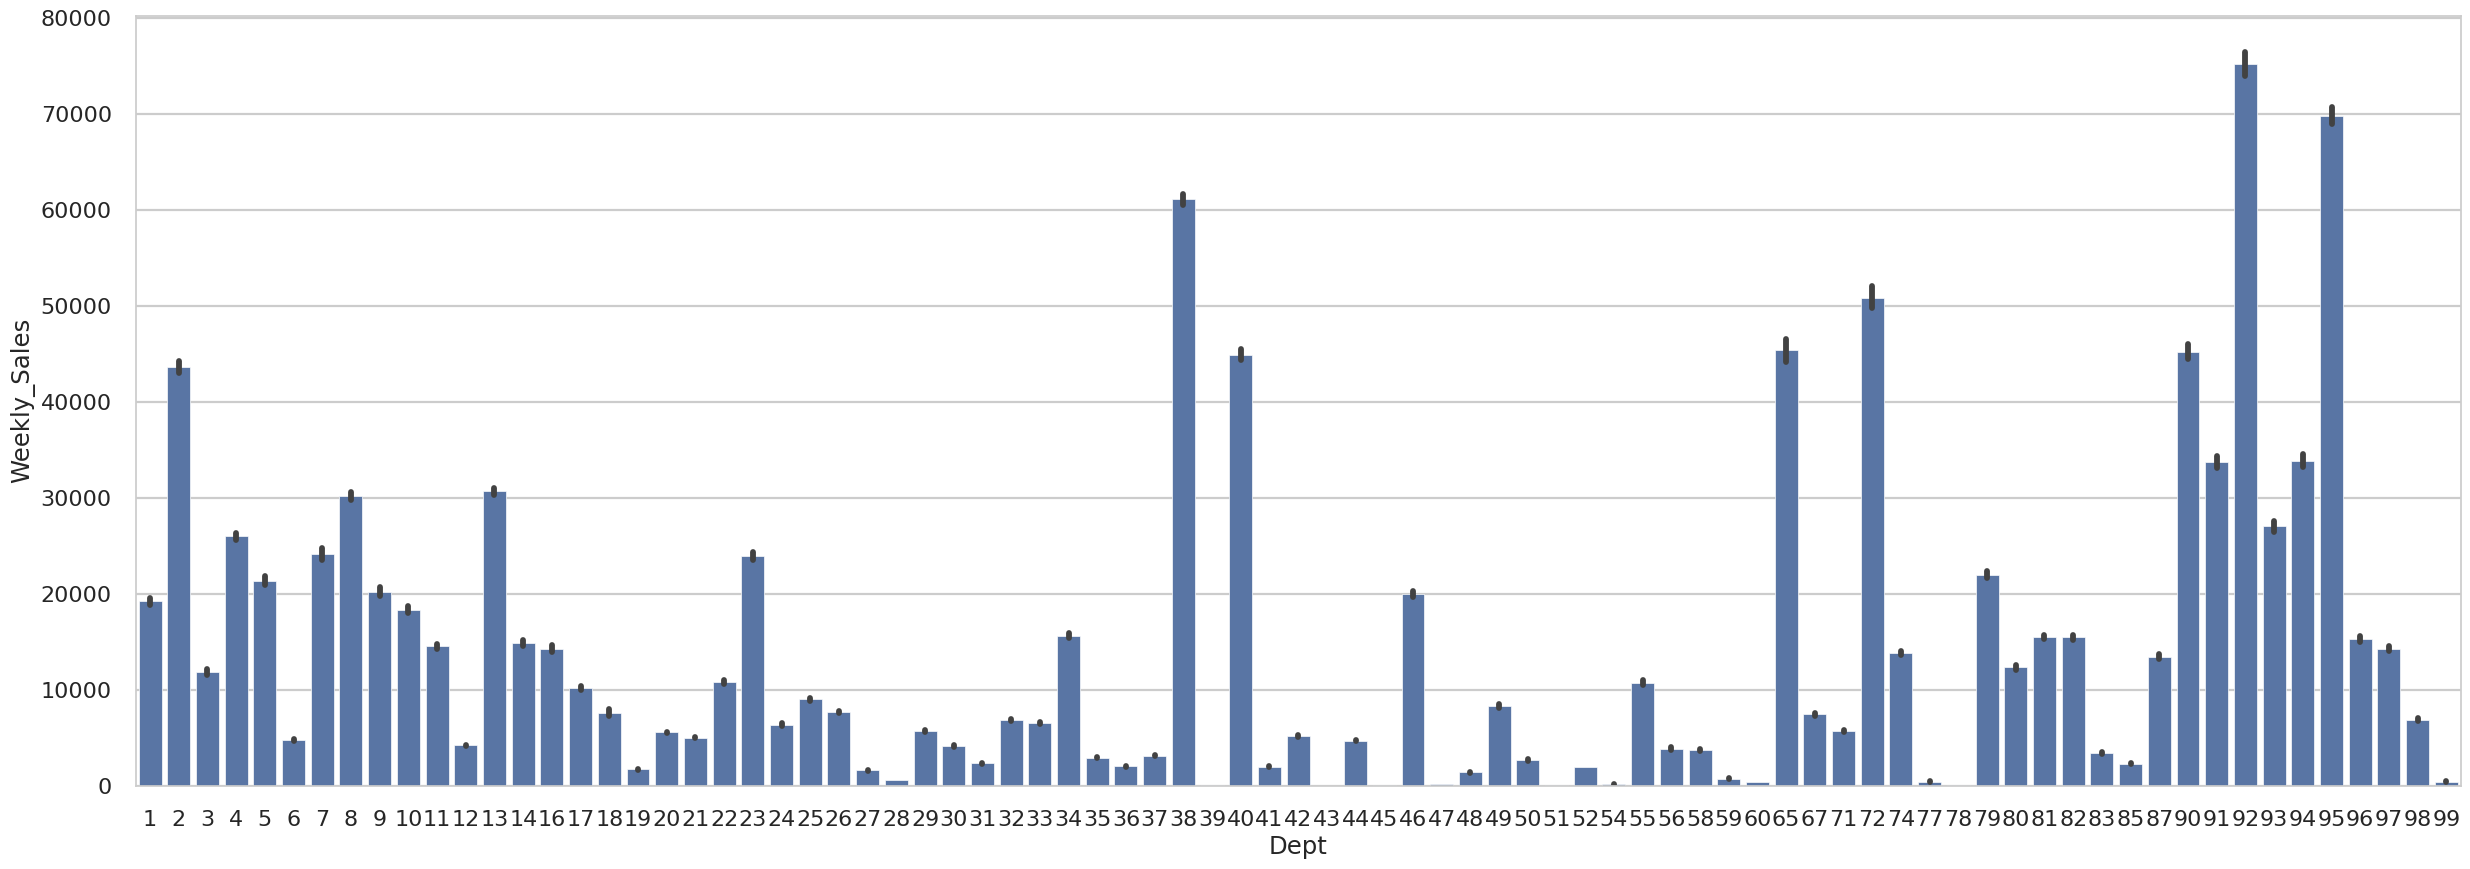

In [ ]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

แผนกที่ 92 มียอดขายสูงที่สุด

**Store vs Weekly_Sales**

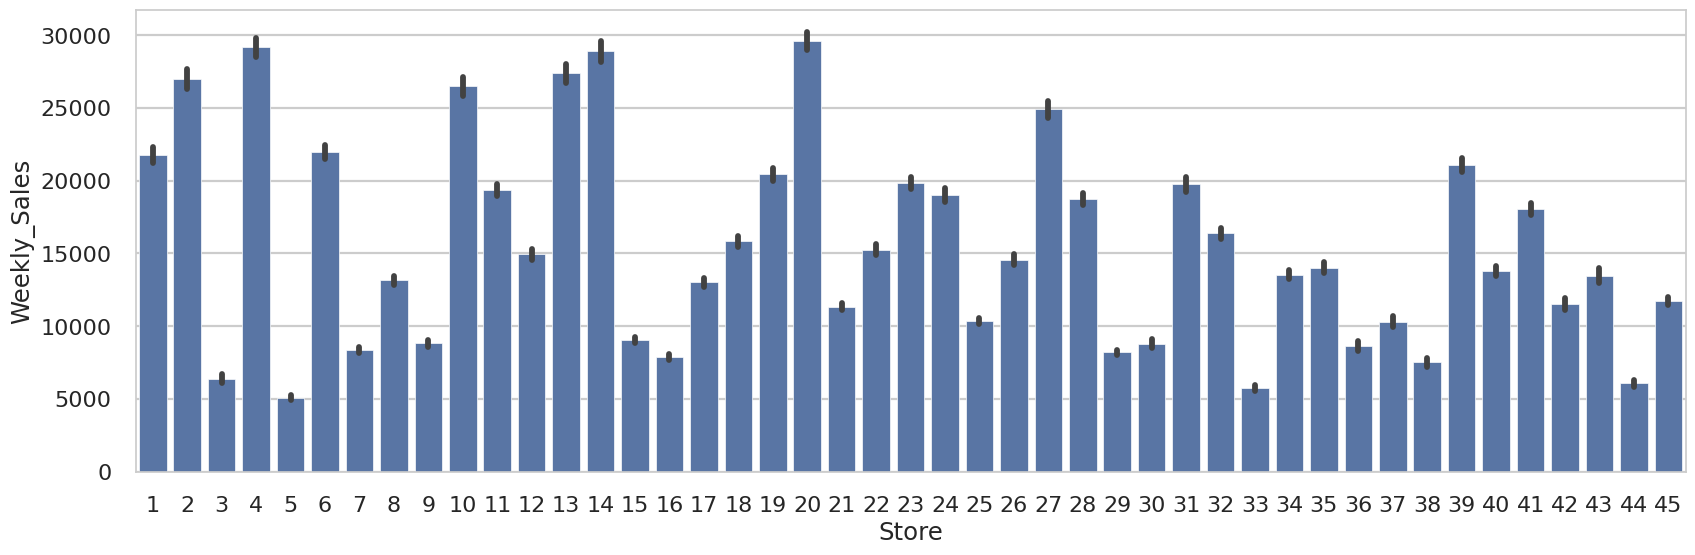

In [ ]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

In [ ]:
df.groupby('Store')[['Weekly_Sales']].sum().sort_values(by='Weekly_Sales',ascending=False).head(3)

,Weekly_Sales
Store,
20,3.014014e+08
4,2.995453e+08
14,2.890019e+08


ยอดขายรายสัปดาห์ของร้านค้าที่ 20 มีค่าสูงที่สุดรอลงมาเป็นร้านค้าที่ 4 และ 14 ตามลำดับ

##Changing Date to Datetime and Creating New Columns

In [ ]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] =df['Date'].dt.week
df['month'] =df['Date'].dt.month
df['year'] =df['Date'].dt.year

In [ ]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

**Weekly_Sales vs month in each years**

<Axes: xlabel='month'>

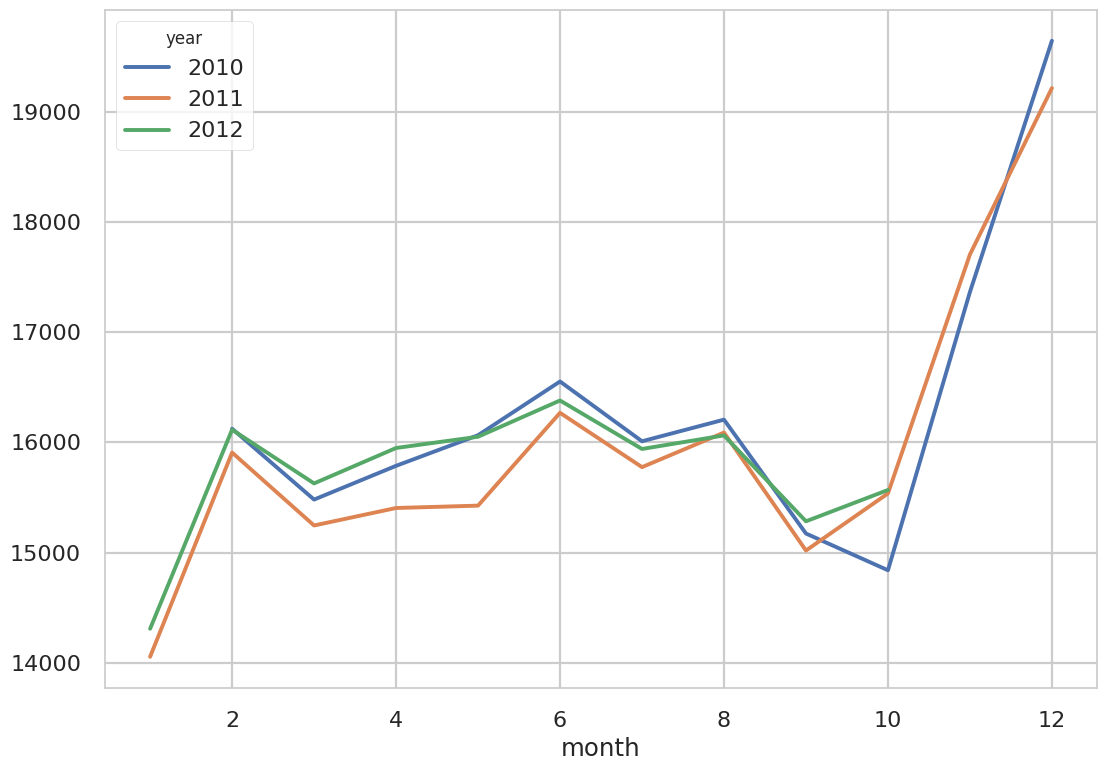

In [ ]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

จากกราฟจะเห็นได้ว่าปี 2011 จะมียอดขายโดยเฉลี่ยน้อยกว่าปี 2010 และ 2012  

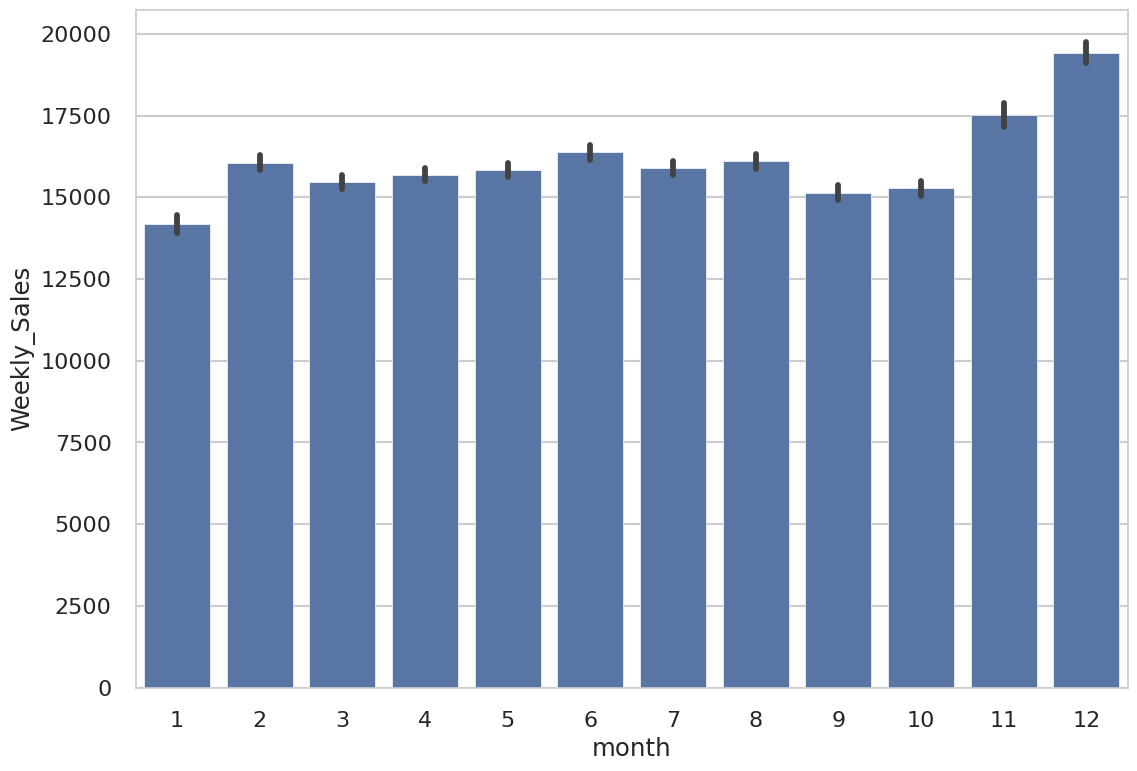

In [ ]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

เมื่อเราดูกราฟด้านบนยอดขายที่ดีที่สุดคือเดือนธันวาคมและพฤศจิกายนตามที่คาดไว้ ค่าสูงสุดเป็นของวันหยุดขอบคุณพระเจ้า แต่เมื่อเราหาค่าเฉลี่ยจะเห็นได้ชัดว่าเดือนธันวาคมมียอดขายสูงที่สุด

In [ ]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

ยอดขายเฉลี่ย 5 อันดับแรกรายสัปดาห์คือ 1-2 สัปดาห์ก่อนวันคริสต์มาส วันขอบคุณพระเจ้า แบล็คฟรายเดย์ และปลายเดือนพฤษภาคม ซึ่งเป็นช่วงที่โรงเรียนปิด

<Axes: xlabel='week'>

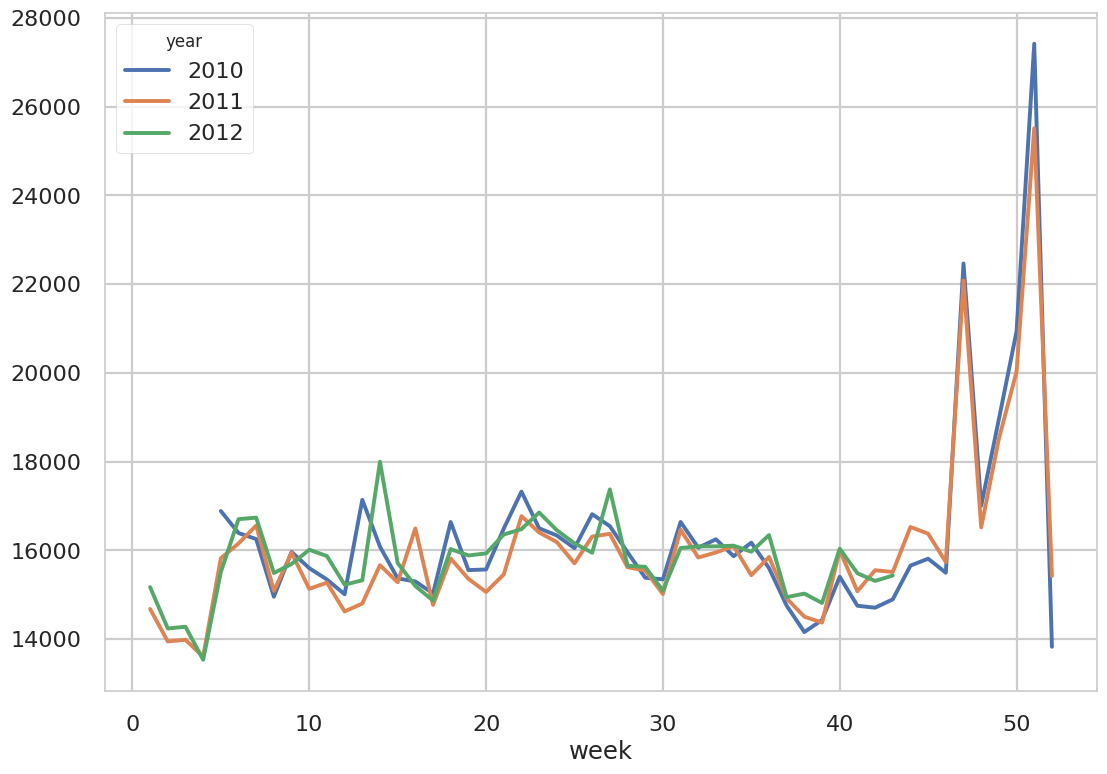

In [ ]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

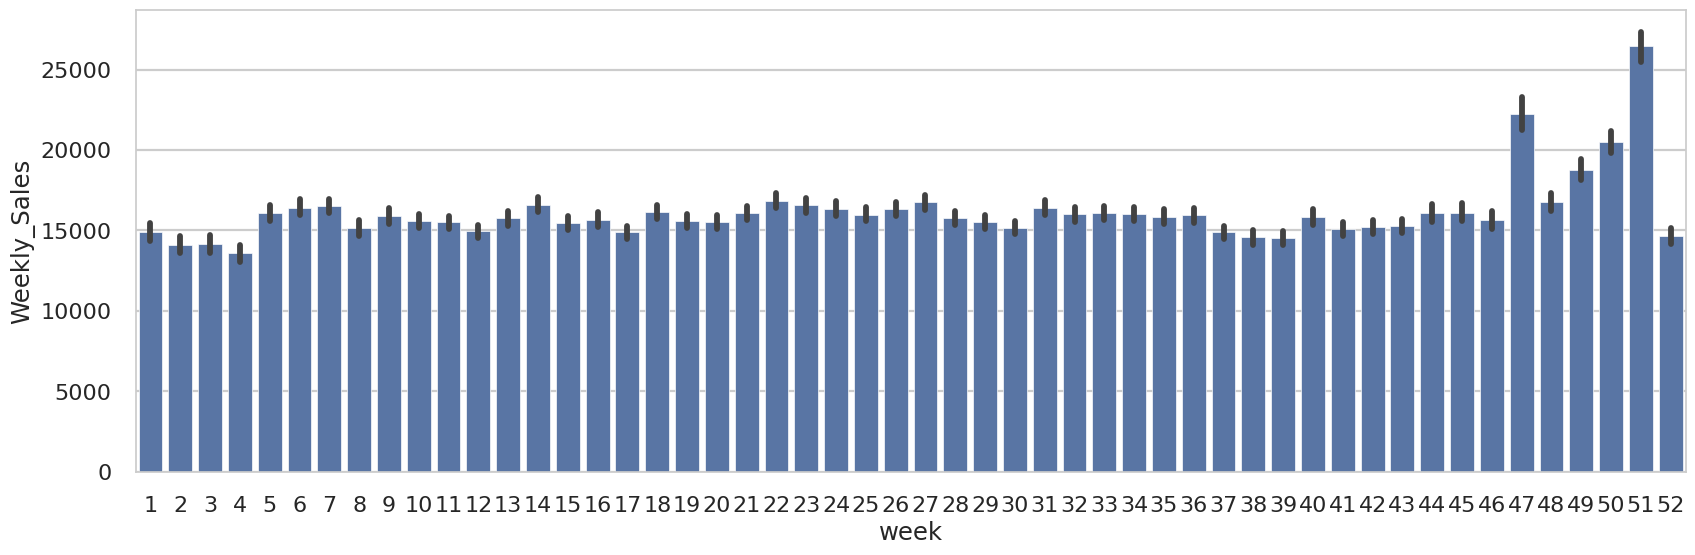

In [ ]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

##Fuel Price, CPI , Unemployment , Temperature Effects

**Fuel Price - ค่าใช้จ่ายพลังงานในแต่ละประเทศ**

<Axes: xlabel='Date'>

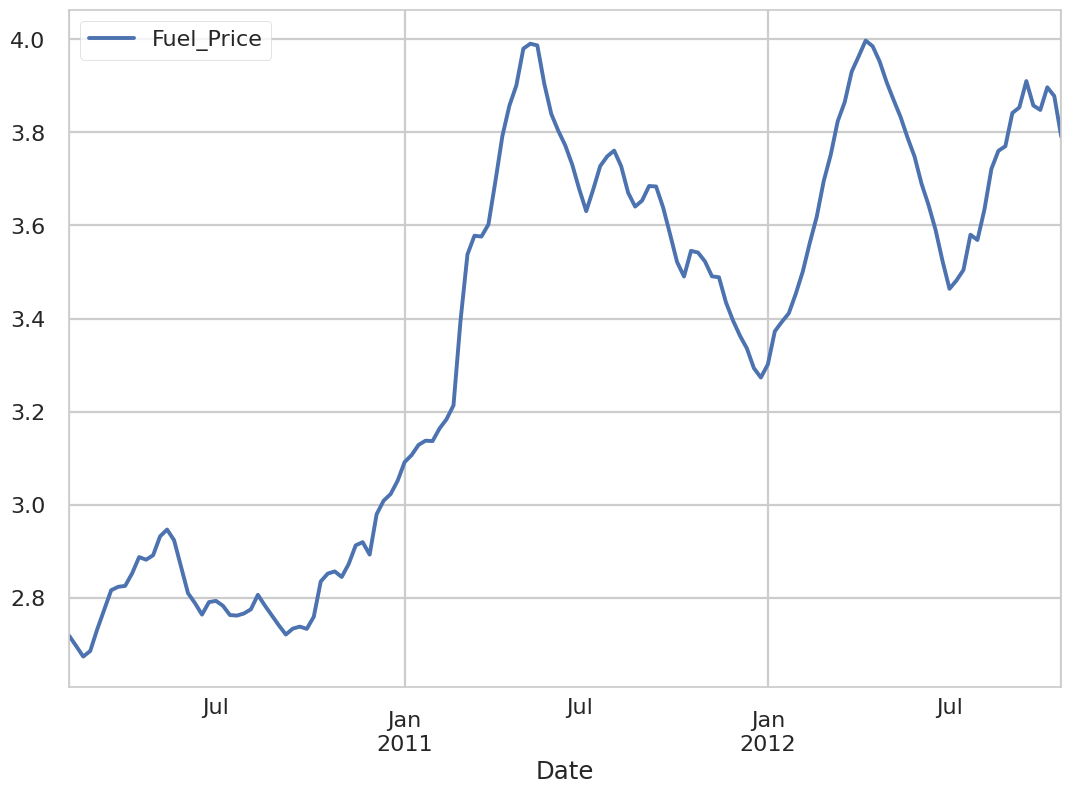

In [ ]:
fuel_price = pd.pivot_table(df, values = "Fuel_Price", index= "Date")
fuel_price.plot()

**Temperature - อุณหภูมิในแต่ละประเทศ(ฟาเรนไฮต์)**

<Axes: xlabel='Date'>

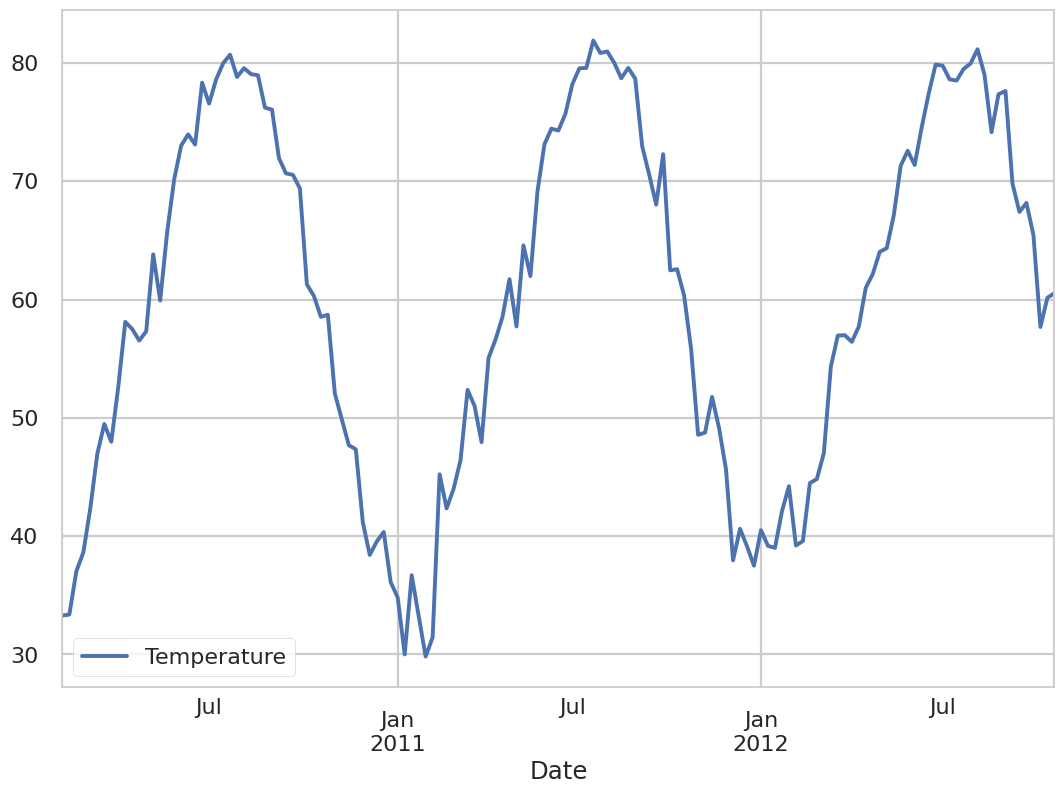

In [ ]:
temp = pd.pivot_table(df, values = "Temperature", index= "Date")
temp.plot()

**CPI(Consumer Price Index) - ดัชนีราคาผู้บริโภค**

- ในการคำนวณดัชนีราคาผู้บริโภคนี้จะนำราคาของสินค้าและบริการในตะกร้าสินค้ามาเปรียบเทียบราคาของช่วงเวลาต่างๆ โดยใช้การคำนวณเป็นเฉลี่ยน้ำหนักของรายการต่างๆ ในตะกร้าสินค้า โดยน้ำหนักของแต่ละรายการจะขึ้นอยู่กับความสำคัญในการบริโภคของครัวเรือน เช่น น้ำหนักของรายการที่เกี่ยวกับที่อยู่อาศัยจะมีน้ำหนักมากกว่ารายการที่เกี่ยวกับความบันเทิง
- เมื่อดัชนีราคาผู้บริโภค เพิ่มขึ้นอย่างรวดเร็ว จะแสดงว่ามีการเพิ่มขึ้นของอัตราเงินเฟ้อนักลงทุนยังใช้ดัชนีราคาผู้บริโภค เพื่อตัดสินใจการลงทุน เช่นเมื่ออัตราเงินเฟ้อเพิ่มขึ้น นักลงทุนอาจเลือกลงทุนในสินทรัพย์ที่ถือว่าเป็นการป้องกันการเพิ่มขึ้นของราคา เช่นทองคำ อสังหาริมทรัพย์ หรือสินค้าโภคภัณฑ์ เป็นต้น

<Axes: xlabel='Date'>

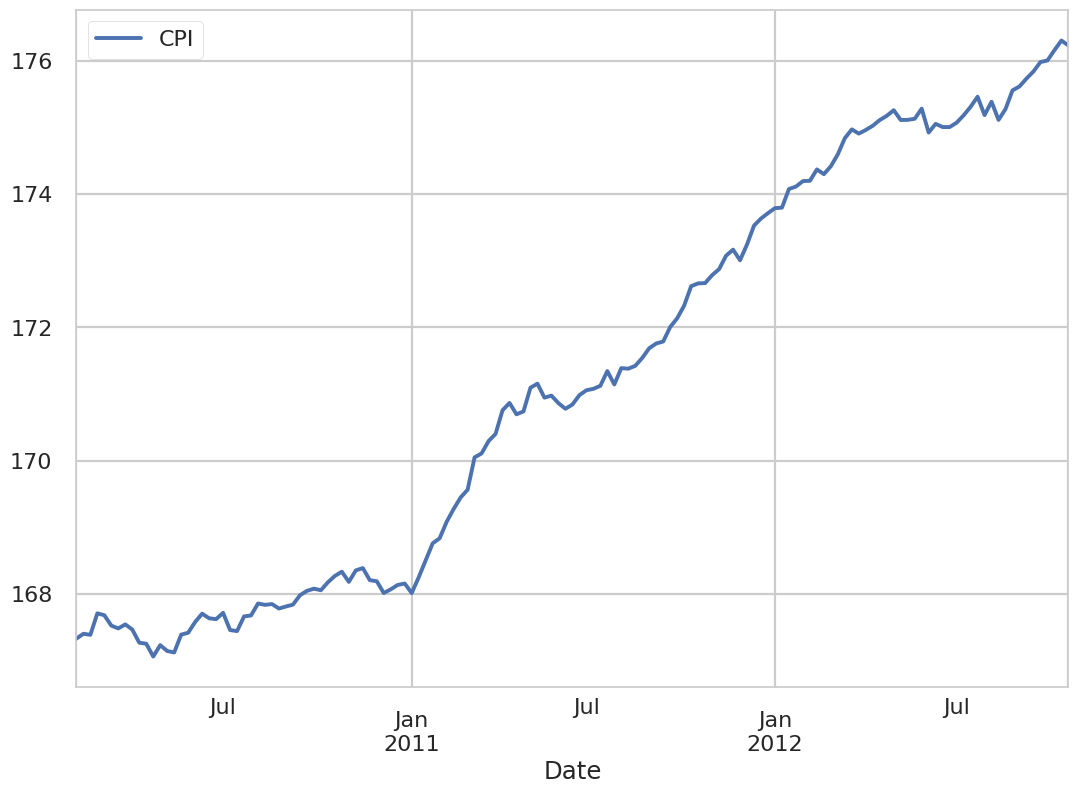

In [ ]:
CPI = pd.pivot_table(df, values = "CPI", index= "Date")
CPI.plot()

**Unemployment -อัตราการว่างงาน**

สะท้อนถึงการจ้างงานในประเทศค่าที่ต่ำบ่งบออกถึงการเติบโตของการจ้า้งงานที่แข็งแกร่งเนื่องจากตลาดแรงงานมีความต้องการแรงงานสูงจากการขยายตัวของธุรกิจที่ทำให้ต้องการแรงงานเพิ่มขึ้น หมายความว่าเศรษฐกิจเติบโตอย่างต่อเนื่องทำให้นำไปสู่แรงกดดันด้านเงินเฟ้อ

<Axes: xlabel='Date'>

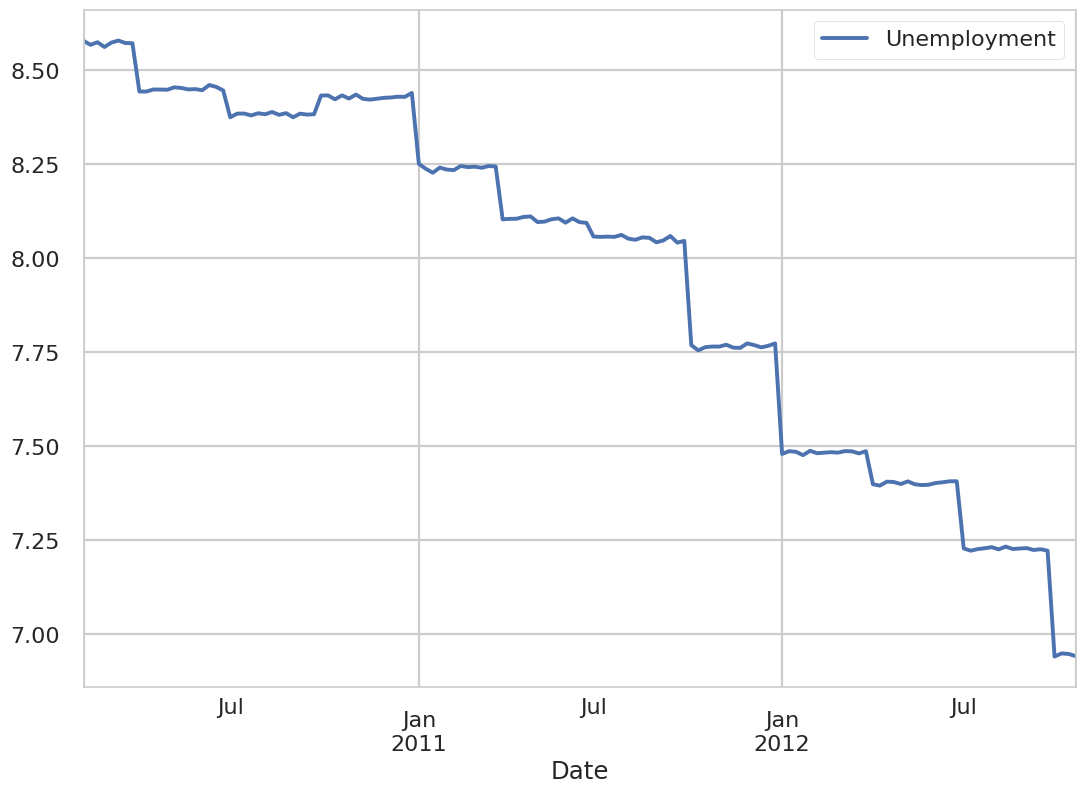

In [ ]:
unemployment = pd.pivot_table(df, values = "Unemployment", index= "Date")
unemployment.plot()

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales. There is no data for CPI between 140-180 also.

In [ ]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here